# 1.0 - MODIS Walkthrough - Download

* Create a ROI (Region of Interest)
* Create a POI (Period of Interest)
* Download MODIS Data
* Download GOES16 Data

In [67]:
import autoroot
import os
from dotenv import load_dotenv
from pathlib import Path
import earthaccess
import numpy as np
import xarray as xr
from dataclasses import dataclass
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# PLOTTING
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



xr.set_options(
    keep_attrs=True, 
    display_expand_data=False, 
    display_expand_coords=False, 
    display_expand_data_vars=False, 
    display_expand_indexes=False
)
np.set_printoptions(threshold=10, edgeitems=2)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ROI

The first thing we need to do is find a region of interest.
We are going to do a very simple example where we define a bounding box.

In [68]:
from odc.geo.xr import xr_coords
from odc.geo.geom import BoundingBox
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.crs import CRS

from odc.geo.data import ocean_geom, country_geom

We will do a simple bounding box around our area of interest.

In [69]:
# create a bounding box from xy
lon_bnds = [-70, -15]
lat_bnds = [20, 5]
bbox = BoundingBox.from_xy(x=lon_bnds, y=lat_bnds, crs="4326")


Now, we will define a geobox which will allow use to create some geometries (for later).

In [70]:

# initialize geobox
resolution = 0.25 # degrees
gbox = GeoBox.from_bbox(bbox, resolution=resolution, crs="4326")

# initialize geometry
odc_crs = CRS("EPSG:4326")
odc_geom = Geometry(geom=bbox.polygon)

### Download MODIS

In [71]:
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID

In [72]:
# environment variables
username = os.environ['EARTHDATA_USERNAME']
password = os.environ['EARTHDATA_PASSWORD']
save_dir = Path(os.getenv("ITI_DATA_SAVEDIR"))
modis_save_dir = save_dir.joinpath("modis_test_images_raw")
modis_save_dir.mkdir(parents=True, exist_ok=True)

We have some extra tools to enable us to select the appropriate satellite.
This is simply syntatic sugar because these names can be a bit difficult to remember.

In [73]:
# select satellite name, "terra" or "aqua", "terra_cloud", "aqua_cloud"
satellite_name = "terra"
# get satellite ID
satellite_id = MODIS_NAME_TO_ID[satellite_name]
# show
satellite_id

'MOD021KM'

Now, we can download the data using the EarthAccess framework.
The main thing we need is the period and (optional) a bounding box.
We don't want to download too much data so we will give a bounding box of interest.

In [74]:
results = earthaccess.search_data(
    short_name=satellite_id,
    cloud_hosted=True,
    bounding_box=bbox.bbox,
    temporal=("2020-10-01 08:00", "2020-10-01 20:00"),
    count=-1
)

Granules found: 6


In [75]:
# results[0]["umm"]

In [76]:
earthaccess.download(results, modis_save_dir)

 Getting 6 granules, approx download size: 0.95 GB


QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

['/pool/usuarios/juanjohn/data/iti/modis_test_images_raw/MOD021KM.A2020275.1200.061.2020276011934.hdf',
 '/pool/usuarios/juanjohn/data/iti/modis_test_images_raw/MOD021KM.A2020275.1205.061.2020276011900.hdf',
 '/pool/usuarios/juanjohn/data/iti/modis_test_images_raw/MOD021KM.A2020275.1340.061.2020276011930.hdf',
 '/pool/usuarios/juanjohn/data/iti/modis_test_images_raw/MOD021KM.A2020275.1345.061.2020276011850.hdf',
 '/pool/usuarios/juanjohn/data/iti/modis_test_images_raw/MOD021KM.A2020275.1515.061.2020276012851.hdf',
 '/pool/usuarios/juanjohn/data/iti/modis_test_images_raw/MOD021KM.A2020275.1520.061.2020276012343.hdf']

### MODIS Files

Now, we will search through our directory for the images.
I can never remember the functions, we have some syntactic sugar functions to help us remember.

In [77]:
from rs_tools._src.geoprocessing.modis import MODIS_WAVELENGTHS, parse_modis_dates_from_file, format_modis_dates
from rs_tools._src.utils.io import get_list_filenames

In [79]:
# list of all .hdf files in the directory
all_modis_files = get_list_filenames(modis_save_dir, ".hdf")

# filter files for terra files ONLY ( our satellite id)
modis_files = list(filter(lambda x: satellite_id in x, all_modis_files))

len(all_modis_files), len(modis_files)

(6, 6)

MODIS files are typically ordered by date. 
So we can parse the dates in the strings using our helper function.
We will use this to grab all of the unique times.

In [80]:
# grab dates
unique_times = list(set(map(parse_modis_dates_from_file, modis_files)))
unique_times

['2020275.1520',
 '2020275.1205',
 '2020275.1200',
 '2020275.1345',
 '2020275.1515',
 '2020275.1340']

### Opening MODIS Files

In general, one can simply open it with xarray with the `netcdf4` back-end.
However, as we will see below, it's messy and very difficult to parse all of the relevant information

In [81]:
img = xr.open_dataset(modis_files[0], engine="netcdf4")
img

<xarray.Dataset> Size: 941MB
Dimensions:                                            (
                                                        2*nscans:MODIS_SWATH_Type_L1B: 406,
                                                        1KM_geo_dim:MODIS_SWATH_Type_L1B: 271,
                                                        Band_1KM_RefSB:MODIS_SWATH_Type_L1B: 15,
                                                        10*nscans:MODIS_SWATH_Type_L1B: 2030,
                                                        Max_EV_frames:MODIS_SWATH_Type_L1B: 1354,
                                                        ...
                                                        number of scans: 203,
                                                        number of 250m bands: 2,
                                                        detectors per 250m band: 40,
                                                        number of 500m bands: 5,
                                                        detectors per 500m band: 20,
                                                        number of 1km reflective bands: 15)
Coordinates: (4)
Dimensions without coordinates: 2*nscans:MODIS_SWATH_Type_L1B,
                                1KM_geo_dim:MODIS_SWATH_Type_L1B,
                                Band_1KM_RefSB:MODIS_SWATH_Type_L1B,
                                10*nscans:MODIS_SWATH_Type_L1B,
                                Max_EV_frames:MODIS_SWATH_Type_L1B,
                                Band_1KM_Emissive:MODIS_SWATH_Type_L1B,
                                ...
                                Band_500M:MODIS_SWATH_Type_L1B,
                                number of emissive bands,
                                detectors per 1km band, number of scans,
                                number of 250m bands, detectors per 250m band,
                                number of 500m bands, detectors per 500m band,
                                number of 1km reflective bands
Data variables: (27)
Attributes: (12/58)
    HDFEOSVersion:                                               HDFEOS_V2.19
    StructMetadata.0:                                            GROUP=SwathS...
    HDFEOS_FractionalOffset_10*nscans_MODIS_SWATH_Type_L1B:      0.0
    HDFEOS_FractionalOffset_Max_EV_frames_MODIS_SWATH_Type_L1B:  0.0
    CoreMetadata.0:                                              \nGROUP     ...
    ArchiveMetadata.0:                                           \nGROUP     ...
    ...                                                          ...
    Detector Quality Flag:                                       [ 0  0 ... 6...
    Detector Quality Flag2:                                      [0 0 ... 0 0]
    Earth-Sun Distance:                                          1.0010378
    Solar Irradiance on RSB Detectors over pi:                   [511.46  511...
    identifier_product_doi:                                      10.5067/MODI...
    identifier_product_doi_authority:                            http://dx.do...

An easier way to open this fil is using the `satpy` package. 
Under the hood, it will parse all of the relevant information from the `hdf5` file.

In [86]:
from satpy import Scene
from typing import List

In [87]:
demo_file: List[str] = [modis_files[0]]
demo_file

['/pool/usuarios/juanjohn/data/iti/modis_test_images_raw/MOD021KM.A2020275.1200.061.2020276011934.hdf']

In [88]:
# create a scene



**Warning**: You need to have the `pyhdf` package installed. 
For some reason the `h5py` package does not work...
If you installed everything from the `environment.yaml` file then it should be fine.

To use the `satpy` package, we simply need to load the channels that interest us.
In our case, we're interested in all of them.
So we will use our helper function to get the list of channels.

In [89]:
# scn.available_dataset_names()

In [90]:
from rs_tools.modis import get_modis_channel_numbers, CALIBRATION_CHANNELS

In [91]:
# load the channels
calibration = "radiance" # "reflectance" # "counts" # "brightness_temperature"
wishlist = CALIBRATION_CHANNELS[calibration]
scn = Scene(
    reader="modis_l1b",
    filenames=demo_file
)
scn.load(wishlist, generate=False, calibration=calibration)


# convert to an xarray
ds = scn.to_xarray_dataset(datasets=wishlist)


In [92]:
# scn.available_dataset_ids()

In [93]:
ds["1"].area

Shape: (2030, 1354)
Lons: <xarray.DataArray 'getitem-92e26a7f80e446772f0b623bec84af8b' (y: 2030, x: 1354)> Size: 11MB
dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes: (12/14)
    standard_name:        longitude
    units:                degree
    platform_name:        EOS-Terra
    sensor:               modis
    rows_per_scan:        10
    start_time:           2020-10-01 12:00:00
    ...                   ...
    name:                 longitude
    resolution:           1000
    modifiers:            ()
    _satpy_id:            DataID(name='longitude', resolution=1000, modifiers...
    long_name:            longitude
    ancillary_variables:  []
Lats: <xarray.DataArray 'getitem-f208778abac3faf0c1ac5555175293bd' (y: 2030, x: 1354)> Size: 11MB
dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes: (12/14)
    standard_name:        latitude
    units:                degree
    platform_name:        EOS-Terra
    sensor:               modis
    rows_per_scan:        10
    start_time:           2020-10-01 12:00:00
    ...                   ...
    name:                 latitude
    resolution:           1000
    modifiers:            ()
    _satpy_id:            DataID(name='latitude', resolution=1000, modifiers=())
    long_name:            latitude
    ancillary_variables:  []

In [94]:
ds["1"].attrs["_satpy_id"]

DataID(name='1', wavelength=WavelengthRange(min=0.62, central=0.645, max=0.67, unit='µm'), resolution=1000, calibration=<3>, modifiers=())

As we can see, each dataarray is a **band** with an associated wavelength (and wavelength range).
We can already showcase what one band looks like.

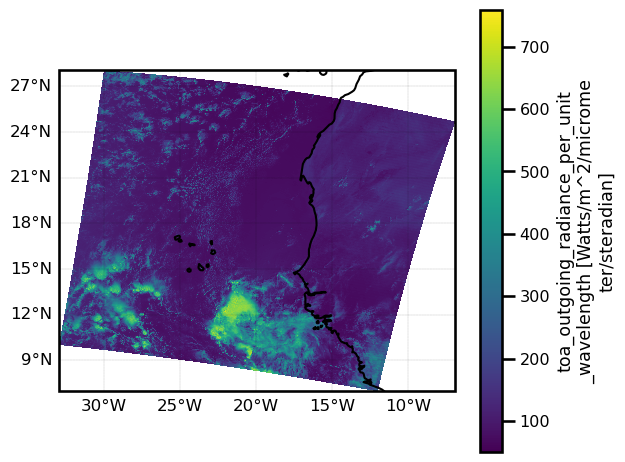

In [95]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

ds["3"].plot(
    ax=ax,
    x="longitude", y="latitude", 
    transform=ccrs.PlateCarree(),
)

ax.set(
    title=""
)
ax.coastlines()

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 
plt.tight_layout()
plt.show()

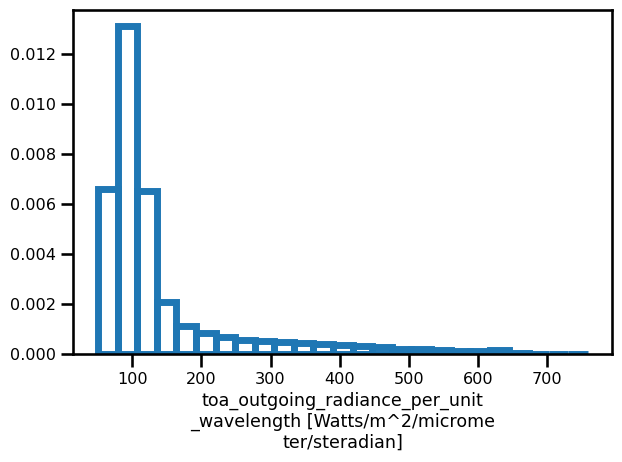

In [96]:
fig, ax = plt.subplots()
ds["3"].plot.hist(ax=ax, edgecolor="tab:blue", linewidth=5, fill=False, bins=25, density=True)
ax.set(
    title=""
)
plt.tight_layout()
plt.show()

## Saving

Our MODIS swath data is a `swath` image. 
In otherwords, it is a curvilinear grid.
This is a weird grid which has weird geometries.
So, xarray is the only option to save this without the option of reprojection.

#### Other Options



We can also opt to save it as `geotiff`.
However, we need to transform it into an image.
The simplest way is to transform it into a rectilinear lat-lon grid.
In a future tutorial, we will look into how we can accomplish that more effectively.

## Script

We have some automated downloading scripts that can help us save a few steps.

In [97]:
from rs_tools._src.data.modis.downloader_aqua import download as aqua_downloader
from rs_tools._src.data.modis.downloader_terra import download as terra_downloader


In [98]:
bbox.bbox
bbox_string = ' '.join(map(str,bbox.bbox))
bbox_string

'-70 5 -15 20'

In [99]:
modis_save_dir

PosixPath('/pool/usuarios/juanjohn/data/iti/modis_test_images_raw')

In [104]:
# aqua_downloader(
#     start_date="2020-10-01",
#     end_date="2020-10-02",
#     start_time="09:00:00",
#     end_time="21:00:00",
#     save_dir="/pool/usuarios/juanjohn/data/iti/pipeline_test/modis/raw",
#     region=bbox_string,
#     cloud_mask=True, 
# );   

terra_downloader(
    start_date="2020-10-01",
    end_date="2020-10-02",
    start_time="09:00:00",
    end_time="21:00:00",
    save_dir="/pool/usuarios/juanjohn/data/iti/pipeline_test/modis/raw",
    region=bbox_string,
    cloud_mask=True, 
);   

2024-07-03 19:13:19.144 | INFO     | rs_tools._src.data.modis.downloader_terra:download:88 - Initializing TERRA Downloader...
2024-07-03 19:13:19.145 | INFO     | rs_tools._src.data.modis.downloader_terra:download:97 - Downloading TERRA Data...
2024-07-03 19:13:20.724 | INFO     | rs_tools._src.data.modis.download:modis_download:96 - Satellite: Terra
2024-07-03 19:13:20.725 | INFO     | rs_tools._src.data.modis.download:modis_download:107 - Data Product: MOD021KM
2024-07-03 19:13:20.743 | INFO     | rs_tools._src.data.modis.download:modis_download:151 - Search parameters: {'short_name': 'MOD021KM', 'bounding_box': (-70, 5, -15, 20)}
Time - 2020-10-01 09:00:00 to 2020-10-01 21:00:00:   0%|                                                                                                                                                                                 | 0/2 [00:00<?, ?it/s]

Granules found: 6
 Getting 6 granules, approx download size: 0.95 GB


QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

Time - 2020-10-02 09:00:00 to 2020-10-02 21:00:00:  50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1/2 [00:32<00:32, 32.67s/it]

Granules found: 7
 Getting 7 granules, approx download size: 1.1 GB


QUEUEING TASKS | :   0%|          | 0/7 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/7 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/7 [00:00<?, ?it/s]

Time - 2020-10-02 09:00:00 to 2020-10-02 21:00:00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:09<00:00, 34.82s/it]
2024-07-03 19:14:30.393 | INFO     | rs_tools._src.data.modis.downloader_terra:download:99 - Done!
2024-07-03 19:14:30.393 | INFO     | rs_tools._src.data.modis.downloader_terra:download:101 - Downloading TERRA Cloud Mask...
2024-07-03 19:14:31.967 | INFO     | rs_tools._src.data.modis.download:modis_download:96 - Satellite: Terra
2024-07-03 19:14:31.968 | INFO     | rs_tools._src.data.modis.download:modis_download:107 - Data Product: MOD35_L2
2024-07-03 19:14:31.978 | INFO     | rs_tools._src.data.modis.download:modis_download:151 - Search parameters: {'short_name': 'MOD35_L2', 'bounding_box': (-70, 5, -15, 20)}
Time - 2020-10-01 09:00:00 to 2020-10-01 21:00:00:   0%|                                                                   

Granules found: 6
 Getting 6 granules, approx download size: 0.08 GB


QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

Time - 2020-10-02 09:00:00 to 2020-10-02 21:00:00:  50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1/2 [00:21<00:21, 21.46s/it]

Granules found: 7
 Getting 7 granules, approx download size: 0.09 GB


QUEUEING TASKS | :   0%|          | 0/7 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/7 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/7 [00:00<?, ?it/s]

Time - 2020-10-02 09:00:00 to 2020-10-02 21:00:00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.14s/it]
2024-07-03 19:15:12.253 | INFO     | rs_tools._src.data.modis.downloader_terra:download:103 - Done!
2024-07-03 19:15:12.253 | INFO     | rs_tools._src.data.modis.downloader_terra:download:105 - Finished TERRA Downloading Script...


## Command-Line Configuration

We also have some command-line scripts that are even more free.

In [101]:
!cat $autoroot.root/config/example/download.yaml

# PERIOD
period:
  start_date: '2020-10-01'
  start_time: '00:00:00'
  end_date: '2020-10-31'
  end_time: '23:59:00'

# CLOUD MASK
cloud_mask: True
  
# PATH FOR SAVING DATA
save_dir: data

defaults:
  - _self_
  


In [102]:
!sed -n 1,9p $autoroot.root/config/example/satellite/aqua.yaml 

download:
  _target_: rs_tools._src.data.modis.downloader_aqua.download
  save_dir: ${save_dir}/aqua/raw
  start_date: ${period.start_date}
  start_time: ${period.start_time}
  end_date: ${period.end_date}
  end_time: ${period.end_time}
  region: "-130 -15 -90 5" # "lon_min lat_min lon_max lat_max"



```python
python rs_tools \
    satellite=aqua \
    stage=download \
    save_dir="/path/to/savedir" \
    period.start_date="2020-10-01" \
    period.end_date="2020-10-02" \
    period.start_time="09:00:00" \
    period.end_time="21:00:00"
```